<a href="https://colab.research.google.com/github/georgeliu1998/keras_model_tuning/blob/master/keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import sklearn
import pickle
from time import time
import importlib # for dynamic class instantiation from a string

#from sklearn import datasets
#from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedKFold, cross_val_score
#from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.datasets import load_iris

import xgboost as xgb

from keras.models import Sequential
from keras.layers import Dense
#from keras import optimizers
#from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import to_categorical

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Using TensorFlow backend.


In [0]:
seed = np.random.RandomState(6)

In [0]:
iris = load_iris()

X = iris['data']
y = iris['target']

In [4]:
clf = xgb.XGBClassifier()
cv = StratifiedKFold(n_splits=5, random_state=seed)

scores = cross_val_score(clf, X, y, cv=cv)

print("Mean Accuracy: {:.2%}, Standard Deviation: {:.2%}".format(scores.mean(), scores.std()))


Mean Accuracy: 95.33%, Standard Deviation: 3.40%


In [0]:
class SequentialModel:
  
  def __init__(self, input_dim, num_layers, num_units, 
               activation, activation_out, 
               loss, initializer, optimizer, learning_rate, 
               metrics, epochs, batch_size, one_hot=False):
    """
    Params:
      input_dim: int, number of features
      num_layers: int, number of layers of the model (excluding the input layer)
      num_units: list, number of units in each layer(excluding the input layer)
      activation: str, activation function used in all layers except output
      activation_out: str, activation function used in output layer
      loss: str, loss functon
      initializer: str, kernel initializer
      optimizer: str, optimizer
      metrics: list of strings, metrics used
      epochs: int, number of epochs to train for
      batch_size: int, number of samples per batch
      one_hot: bool, whether one hot encoding is needed
    """
    self.input_dim = input_dim
    self.num_layers = num_layers
    self.num_units = num_units
    self.activation = activation
    self.activation_out = activation_out
    self.loss = loss
    self.initializer = initializer
    self.optimizer = optimizer
    self.learning_rate = learning_rate
    self.metrics = metrics
    self.epochs = epochs
    self.batch_size = batch_size
    self.one_hot = one_hot
    
    # Initialize the sequential model
    self.model = Sequential()
  
    
  def build_model(self):
    """
    Adds layers and compiles the model
    """
    # Ensure num_units tuple's length is the same as num_layers
    if self.num_layers != len(self.num_units):
      # Expand the list by repeating number of nodes except for last layer
      num_nodes, num_nodes_out = self.num_units[0], self.num_units[-1]
      self.num_units = [i for i in range(num_layers-1) for i in [num_nodes]]
      self.num_units.append(num_nodes_out) 
    
    # Loop thru all the layers
    for i in range(self.num_layers):
      # Different layers should have different setups
      if i == 0: # first layer
        self.model.add(Dense(units=self.num_units[i],
                             input_dim=self.input_dim,
                             kernel_initializer=initializer,
                             activation=activation)) 
      elif i+1 == self.num_layers: # output layer
        self.model.add(Dense(units=self.num_units[i],
                             kernel_initializer=initializer,
                             activation=activation_out))
      else:
        self.model.add(Dense(units=self.num_units[i],
                            kernel_initializer=initializer,
                            activation=activation))
    
    # Instantiate the optimizer class
    optimizer_class = getattr(importlib.import_module("keras.optimizers"), 
                             self.optimizer)
    self.optimizer = optimizer_class(lr=self.learning_rate)
    # Compile the model
    self.model.compile(loss=self.loss,
                       optimizer=self.optimizer,
                       metrics=self.metrics)
      
  
  
  def evaluate_model(self, X, y, n_splits=3):
    """
    Evaluates the model using cross-validation.
    
    Params:
      X: np.array, features
      y: np.array, labels
      n_splits: int, number of folds for the cross-validation
    Returns:
      mean_accuracy: float, the average accuracy based on the cross-validation.
    
    """
    score_lst = []
    t1 = time()
    
    print("Starting {}-fold cross-validation...".format(n_splits))
    
    kfold = StratifiedKFold(n_splits=n_splits, 
                            shuffle=True, 
                            random_state=seed)
    
    # Loop through the different folds
    for train_index, test_index in kfold.split(X, y):
      # Do one-hot encoding when needed
      if self.one_hot:
        y_one_hot = to_categorical(y)
      else:
        y_one_hot = y
        
      self.model.fit(X[train_index],
                     y_one_hot[train_index],
                     epochs=self.epochs,
                     batch_size=self.batch_size,
                     verbose=1)
        
      scores = self.model.evaluate(X[test_index],
                                   y_one_hot[test_index], 
                                   verbose=1)
            
      # The second item is accuracy
      score_lst.append(scores[1])

    t2 = time()
    t = t2 - t1
    # Convert time to mintues
    t /= 60

    print("Finished cross-valiation. Took {:.1f} mintues.".format(t))

    # Convert to np.array and calculate mean and sd
    score_lst = np.array(score_lst)
    mean_acc = score_lst.mean()
    sd_acc = score_lst.std()

    print("Mean Accuracy: {:.2%}, Standard Deviation: {:.2%}".format(mean_acc, sd_acc))
    return mean_acc

In [6]:
input_dim = 4
num_layers = 2
num_units = (4, 3) 
activation = 'relu'
activation_out = 'softmax'
loss = 'binary_crossentropy'
initializer = 'random_uniform'
optimizer = 'adam'
learning_rate = 0.001
metrics = ['accuracy']
epochs = 100
batch_size = 5
one_hot = True


model = SequentialModel(input_dim=input_dim, 
                        num_layers=num_layers, 
                        num_units=num_units,
                        activation=activation, 
                        activation_out=activation_out, 
                        loss=loss, 
                        initializer=initializer, 
                        optimizer=optimizer, 
                        learning_rate=learning_rate, 
                        metrics=metrics, 
                        epochs=epochs, 
                        batch_size=batch_size, 
                        one_hot=one_hot)

model.build_model()
model.evaluate_model(X, y)

Starting 3-fold cross-validation...
Epoch 1/100
99/99 [==============================] - 1s 10ms/step - loss: 0.6367 - acc: 0.6667
Epoch 2/100
99/99 [==============================] - 0s 953us/step - loss: 0.6361 - acc: 0.6667
Epoch 3/100
99/99 [==============================] - 0s 989us/step - loss: 0.6351 - acc: 0.6667
Epoch 4/100
99/99 [==============================] - 0s 1ms/step - loss: 0.6335 - acc: 0.6667
Epoch 5/100
99/99 [==============================] - 0s 924us/step - loss: 0.6311 - acc: 0.6667
Epoch 6/100
99/99 [==============================] - 0s 942us/step - loss: 0.6272 - acc: 0.6667
Epoch 7/100
99/99 [==============================] - 0s 994us/step - loss: 0.6218 - acc: 0.6667
Epoch 8/100
99/99 [==============================] - 0s 1ms/step - loss: 0.6151 - acc: 0.6667
Epoch 9/100
99/99 [==============================] - 0s 1ms/step - loss: 0.6066 - acc: 0.6667
Epoch 10/100
99/99 [==============================] - 0s 1ms/step - loss: 0.5971 - acc: 0.6667
Epoch 11/100

0.9621459794979469

In [0]:
!pip install kaggle
api_token = {"username":"georgeliu","key":"API_KEY"}
import json
import zipfile
import os
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)
!chmod 600 /content/.kaggle/kaggle.json
!kaggle config path -p /content

In [7]:
pima = pd.read_csv("/content/pima-indians-diabetes.csv", header=None)
pima.head()

,0,1,2,3,4,5,6,7,8
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [8]:
X_pima, y_pima = pima.values[:, 0:8], pima.values[:, 8]
print(X_pima.shape, y_pima.shape)

(768, 8) (768,)


In [9]:
input_dim = 8
num_layers = 2
num_units = (8, 1) 
activation = 'relu'
activation_out = 'sigmoid'
loss = 'binary_crossentropy'
initializer = 'random_uniform'
optimizer = 'adam'
learning_rate = 0.001
metrics = ['accuracy']
epochs = 10
batch_size = 5
one_hot = False


model = SequentialModel(input_dim=input_dim, 
                        num_layers=num_layers, 
                        num_units=num_units,
                        activation=activation, 
                        activation_out=activation_out, 
                        loss=loss, 
                        initializer=initializer, 
                        optimizer=optimizer, 
                        learning_rate=learning_rate, 
                        metrics=metrics, 
                        epochs=epochs, 
                        batch_size=batch_size, 
                        one_hot=one_hot)

model.build_model()
model.evaluate_model(X_pima, y_pima)

Starting 3-fold cross-validation...
Epoch 1/10
511/511 [==============================] - 1s 1ms/step - loss: 0.6757 - acc: 0.6517
Epoch 2/10
511/511 [==============================] - 0s 940us/step - loss: 0.6604 - acc: 0.6438
Epoch 3/10
511/511 [==============================] - 0s 948us/step - loss: 0.6500 - acc: 0.6380
Epoch 4/10
511/511 [==============================] - 1s 1ms/step - loss: 0.6420 - acc: 0.6497
Epoch 5/10
511/511 [==============================] - 1s 1ms/step - loss: 0.6320 - acc: 0.6399
Epoch 6/10
511/511 [==============================] - 1s 1ms/step - loss: 0.6238 - acc: 0.6536
Epoch 7/10
511/511 [==============================] - 1s 1ms/step - loss: 0.6227 - acc: 0.6810
Epoch 8/10
511/511 [==============================] - 1s 1ms/step - loss: 0.6169 - acc: 0.6634
Epoch 9/10
511/511 [==============================] - 1s 1ms/step - loss: 0.6117 - acc: 0.6791
Epoch 10/10
257/257 [==============================] - 0s 258us/step
Epoch 1/10
512/512 [================

0.6810626389393925

In [0]:
width = [8, 16, 32, 64]
depth = [2, 4, 8, 16]
loss = ['binary_crossentropy', 'categorical_crossentropy', 'sparse_categorical_crossentropy']
initializer = ['random_uniform', 'random_normal', 'glorot_normal', 'glorot_uniform']
learning_rate = [0.001, 0.01, 0.1, 1]
optimizer = ['adam', 'adagrad', 'sgd', 'rmsprop']
epochs = [10, 20, 40, 100]
batch_size = [1, 5, 10, 15]


tuning_options = {'width': width,
                  'depth': depth, 
                  'loss': loss, 
                  'initializer': initializer, 
                  'optimizer': optimizer, 
                  'learning_rate': learning_rate,
                  'epochs': epochs, 
                  'batch_size': batch_size}

In [11]:
results = {}

for parameter, options in tuning_options.items():
  
  results[parameter] = {}
  
  input_dim = 8
  num_layers = 2
  num_units = (8, 1) 
  activation = 'relu'
  activation_out = 'sigmoid'
  loss = 'binary_crossentropy'
  initializer = 'random_uniform'
  learning_rate = 0.001
  optimizer = 'adam'
  metrics = ['accuracy']
  epochs = 10
  batch_size = 5
  one_hot = False

  for option in options:
    
    if parameter == 'width':
      num_units = (option, 1)
    elif parameter == 'depth':
      num_layers = option
    elif parameter == 'loss':
      loss = option
    elif parameter == 'initializer':
      initializer = option
    elif parameter == 'optimizer':
      optimizer = option
    elif parameter == 'learning_rate':
      learning_rate = option
    elif parameter == 'epochs':
      epochs = option
    else:
      batch_size = option
    
    print("\nEvaluating parameter \"{}\" using value \"{}\"...".format(parameter, option))
    
    model = SequentialModel(input_dim=input_dim, 
                            num_layers=num_layers, 
                            num_units=num_units,
                            activation=activation, 
                            activation_out=activation_out, 
                            loss=loss, 
                            initializer=initializer, 
                            optimizer=optimizer, 
                            learning_rate=learning_rate, 
                            metrics=metrics, 
                            epochs=epochs, 
                            batch_size=batch_size, 
                            one_hot=one_hot)
    
    try:
      model.build_model()
      result = model.evaluate_model(X_pima, y_pima)  
      results[parameter][option] = result
    except:
      results[parameter][option] = 'NaN'
      print('Error, skipped.')
      pass

# Save the dict    
with open('cross_validation_results.pkl', 'wb') as f:
    pickle.dump(results, f, pickle.HIGHEST_PROTOCOL)


Evaluating parameter "width" using value "8"...
Starting 3-fold cross-validation...
Epoch 1/10
511/511 [==============================] - 1s 2ms/step - loss: 0.6919 - acc: 0.5832
Epoch 2/10
511/511 [==============================] - 1s 1ms/step - loss: 0.6825 - acc: 0.6536
Epoch 3/10
511/511 [==============================] - 1s 1ms/step - loss: 0.6756 - acc: 0.6517
Epoch 4/10
511/511 [==============================] - 1s 1ms/step - loss: 0.6699 - acc: 0.6517
Epoch 5/10
511/511 [==============================] - 1s 1ms/step - loss: 0.6640 - acc: 0.6497
Epoch 6/10
511/511 [==============================] - 1s 1ms/step - loss: 0.6494 - acc: 0.6536
Epoch 7/10
511/511 [==============================] - 1s 1ms/step - loss: 0.6411 - acc: 0.6575
Epoch 8/10
511/511 [==============================] - 1s 1ms/step - loss: 0.6319 - acc: 0.6517
Epoch 9/10
511/511 [==============================] - 1s 1ms/step - loss: 0.6231 - acc: 0.6712
Epoch 10/10
257/257 [==============================] - 0s 31

In [0]:
with open('cross_validation_results.pkl', 'rb') as f:
    tuning_results = pickle.load(f)

In [0]:
def wrangle(tuning_results):
    """
    Params:
        tuning_results: dict, the dict loaded from pickled hyperparameter tuning results
    
    Returns:
        df_long: pandas df, the wrangled long format dataframe
    """
    # Save as df
    df = pd.DataFrame(tuning_results)
    # Get the col names as value vars for melt func
    value_vars = df.columns.tolist()
    # Reset index and rename the index col 
    df = df.reset_index().rename(columns={'index': 'option'})
    # Transform from wide to long format for easy plotting
    df_long = pd.melt(df, id_vars='option', value_vars=value_vars)
    df_long = df_long.rename(columns={'variable': 'parameter'})
    # Exclude the zero and null values
    df_long = df_long[~df_long['value'].isnull()]
    df_long = df_long.query("value!=0 & value!='NaN'")
    
    return df_long

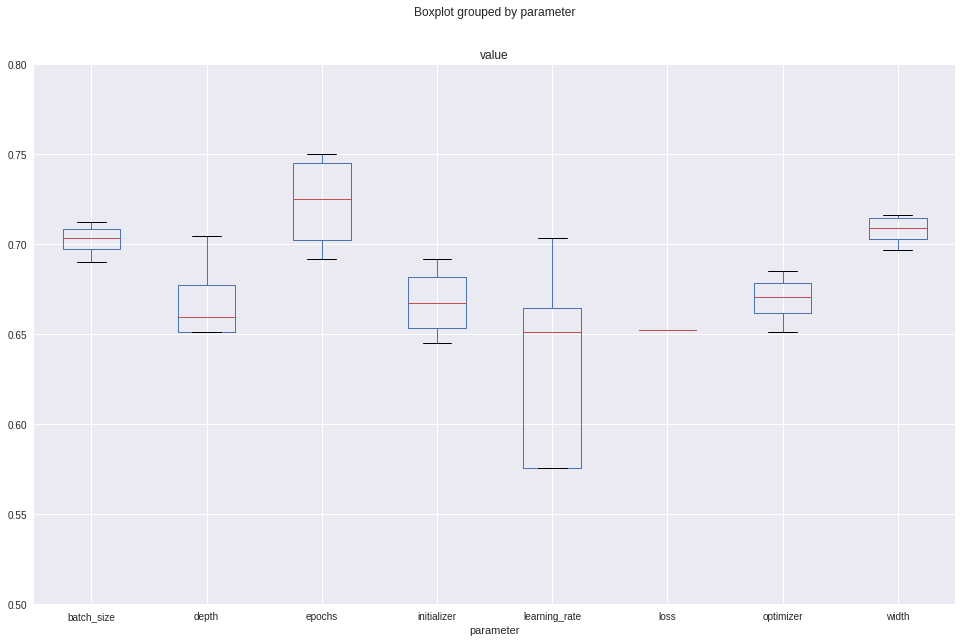

In [20]:
df_long = wrangle(tuning_results)
fig, ax = plt.subplots(figsize=(16, 10))
df_long.boxplot(column='value', by='parameter', ax=ax)
plt.ylim(0.5, 0.8)
plt.show()